# Environment setup
(The project folder needs to be added to your gdrive for everything to work without editing)

In [0]:
!pip install ortools # Google's solver library

     |████████████████████████████████| 27.9MB 110kB/s 
     |████████████████████████████████| 1.3MB 45.2MB/s 
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [0]:
# General libraries (q commonly used in most stuff)
import matplotlib.pyplot as plt # Basic plotting library
import numpy as np              # Work with arrays and matrices efficiently
import pandas as pd             # Work with tables nicely
import seaborn as sns           # Nicer interface to matplotlib.pyplot

# Other libraries
from collections import defaultdict
from google.colab import drive
from ortools.linear_solver import pywraplp
from pathlib import Path

drive.mount('content/')
sns.set()

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data
In general,
- XXXX_info.csv files contain information related only to XXXX
- XXXX_YYYY.csv files contain information relating XXXX to YYYY

These files are prepared in the data_preprocessing notebook.

In [0]:
root = Path('content/My Drive/IE4210 Group Project')
data = root / 'data'

In [0]:
jobs_info = pd.read_csv(data/'jobs_info.csv').set_index('Job Classification')
jobs_skills = pd.read_csv(data/'jobs_skills.csv').set_index('Job Classification')

prog_info = pd.read_csv(data/'prog_info.csv').set_index('Program')
prog_skills = pd.read_csv(data/'prog_skills.csv').set_index('Program')
prog_clash = pd.read_csv(data/'prog_clash.csv').set_index('Program')

skills_info = pd.read_csv(data/'skills_info.csv').set_index('Number')

In [0]:
jobs_skills.sample()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
Job Classification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Technician,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


In [0]:
prog_info.sample()

,Enrollment Cost ($),Duration (days)
Program,,
3,500,4


In [0]:
skills_info.sample()

,Skill
Number,
33,Substance abuse


# Q1: Program assignment
The company's optimization problem is broken into a set of subproblems since job assignments are independent of each other. Each subproblem assigns programs for each job type while taking into account program costs ($z_1$), program durations ($z_2$) and the number of years it takes to cover all skills ($z_3$).

## Sets
- $J$ is the set of jobs indexed by $j$
- $P$ is the set of programs indexed by $p$
- $S$ is the set of skills indexed by $s$
- $Y$ is the set of years indexed by $y$

## Parameters
- $k_j$ cost/employee/day of job $j$
- $c_p$ cost/employee of program $p$
- $t_p$ duration (days) of program $p$

## Variables
- $x_{j,p,y}=1$ if job $j$ is assigned program $p$ in year $y$ else $0$

## Objective
- $z_1 = \sum_{j \in J, p \in P, y \in Y}(c_{p}.x_{j,p,y})$ is the actual cost
- $z_2 = \sum_{j \in J, p \in P, y \in Y}(k_{j}.t_{p}.x_{j,p,y})$ is the opportunity cost
- $\min z_1 + z_2$

In [0]:
# Sets
J = jobs_info.index
P = prog_info.index
S = skills_info.index
Y = np.arange(3) # The number of years

# Parameters
k = jobs_info['Salary ($)'] / 250 # annual salary / workdays per year
c = prog_info['Enrollment Cost ($)']
t = prog_info['Duration (days)']

subproblem = dict()
for j in J:
  model = pywraplp.Solver(f'{j} assignment', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
  
  # Variables
  x = defaultdict(dict)
  for p in P:
    for y in Y:
      x[p][y] = model.BoolVar(f'assign program {p} in year {y}')
  
  # Objective function
  z1 = sum(c[p]*x[p][y] for j in J for p in P for y in Y)
  z2 = sum(k[j]*t[p]*x[p][y] for j in J for p in P for y in Y)
  model.Minimize(z1 + z2)

  # Program constraints
  for p1 in P:
    for p2 in P:
      if (p2 > p1) and prog_clash.loc[p1, str(p2)] == 1:
        for y in Y:
          model.Add(x[p1][y] + x[p2][y] <= 1, f'year {y} {p1} {p2} clash')
  
  # Skill constraints
  for s in S:
    if jobs_skills.loc[j, str(s)] == 1:
      model.Add(sum(x[p][y] for p in P for y in Y if prog_skills.loc[p, str(s)]) >= 1, f'skill {s}')

  # Annual constraints
  for y in Y:
    model.Add(sum(x[p][y] for p in P) <= 5, f'year {y} max programs')
    model.Add(sum(t[p]*x[p][y] for p in P) >= 5, f'year {y} min hours')
    model.Add(sum(t[p]*x[p][y] for p in P) <= 15, f'year {y} max hours')

  subproblem[j] = (model, x, z1, z2)

In [0]:
# Tabulate results
objective_records = list()
solutions_records = list()
for j, (model, x, z1, z2) in subproblem.items():
  if model.Solve() == model.OPTIMAL:
    objective_records.append({
        'job': j,
        'real cost': z1.solution_value(),
        'opp. cost': z2.solution_value(),
        'total': model.Objective().Value(),
    })
    solutions_records.extend([{
        'job': j, 
        'program': p, 
        'year': y, 
        'assignment': x[p][y].solution_value()
    } for p in P for y in Y])

base_objective = pd.DataFrame.from_records(objective_records).set_index('job')
base_solutions = pd.DataFrame.from_records(solutions_records)
base_solutions['cost'] = c[base_solutions.program].values * base_solutions.assignment
base_solutions['time'] = t[base_solutions.program].values * base_solutions.assignment

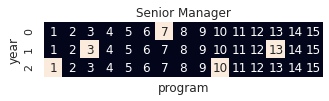

real cost    12600.0
opp. cost    63240.0
total        75840.0
Name: Senior Manager, dtype: float64


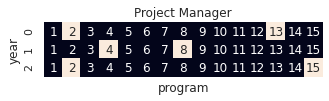

real cost    19650.0
opp. cost    55800.0
total        75450.0
Name: Project Manager, dtype: float64


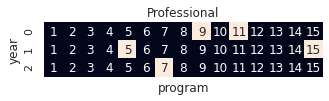

real cost    15600.0
opp. cost    55800.0
total        71400.0
Name: Professional, dtype: float64


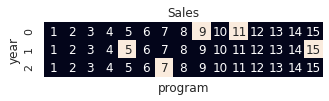

real cost    15600.0
opp. cost    55800.0
total        71400.0
Name: Sales, dtype: float64


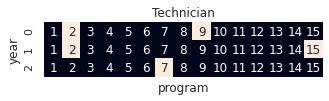

real cost    10200.0
opp. cost    55800.0
total        66000.0
Name: Technician, dtype: float64


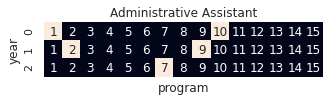

real cost    10200.0
opp. cost    55800.0
total        66000.0
Name: Administrative Assistant, dtype: float64


In [0]:
for j in J:
  # Plot assignments
  plt.figure(figsize=(5, 1))
  sns.heatmap(
      data = base_solutions[base_solutions.job==j].pivot('year', 'program', 'assignment'), 
      annot = len(Y)*[P], 
      cbar=False, 
      xticklabels=False
  ).set_title(j)
  plt.show()

  # Print Objectives
  print(base_objective.loc[j])

# Q2 & Q3: Candidate programs for in-house development
Programs with the highest associated cost across assignments are top candidates for in-house development. The company should be willing to pay up to the cost incurred for that course to develop an in-house alternative.

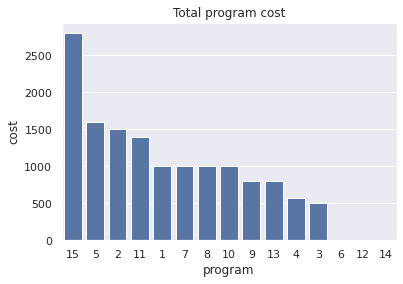

In [0]:
data = base_solutions.groupby('program').sum()
data = data.sort_values('cost', ascending=False)
ax = sns.barplot(data.index, data.cost, order=data.index, color='b')
ax.set_title('Total program cost')
plt.show()

# Q3: Candidate programs for price negotiation
Programs with the largest total assignments are top candidates for negotiation as each dollar saved through negotiations affects the objective proportionally to the number of total assignments. This can be derived from the derivative of the objective function wrt. program costs: 
> $\frac{\partial z_1}{\partial c_p} = \frac{\partial}{\partial c_p} \sum_{j \in J, p \in P, y \in Y}(c_{p}.x_{j,p,y}) = \sum_{j \in J, y \in Y}(x_{j,p,y})$

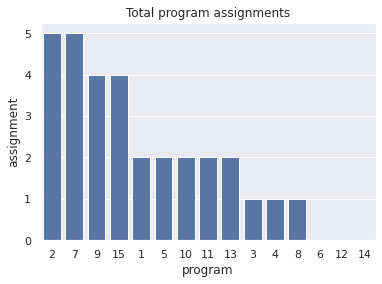

In [0]:
data = base_solutions.groupby('program').sum()
data = data.sort_values('assignment', ascending=False)
ax = sns.barplot(data.index, data.assignment, order=data.index, color='b')
ax.set_title('Total program assignments')
plt.show()

# Q4: Skills cost analysis
For each skill, each subproblem is re-solved without the corresponding skill constraints and the improvement in objective value is recorded. The improvement is equivalent to the cost incurred for the inclusion of that skill.

In [0]:
# Sets
J = jobs_info.index
P = prog_info.index
S = skills_info.index
Y = np.arange(3) # The number of years

# Parameters
k = jobs_info['Salary ($)'] / 250 # annual salary / workdays per year
c = prog_info['Enrollment Cost ($)']
t = prog_info['Duration (days)']

skill_delta = pd.DataFrame(index=J, columns=None)
for skill in S:
  temp_skills = jobs_skills.copy()
  temp_skills[str(skill)] = 0
  subproblem = dict()
  for j in J:
    model = pywraplp.Solver(f'{j} assignment', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # Variables
    x = defaultdict(dict)
    for p in P:
      for y in Y:
        x[p][y] = model.BoolVar(f'assign program {p} in year {y}')
    
    # Objective function
    z1 = sum(c[p]*x[p][y] for j in J for p in P for y in Y)
    z2 = sum(k[j]*t[p]*x[p][y] for j in J for p in P for y in Y)
    model.Minimize(z1 + z2)

    # Program constraints
    for p1 in P:
      for p2 in P:
        if (p2 > p1) and prog_clash.loc[p1, str(p2)] == 1:
          for y in Y:
            model.Add(x[p1][y] + x[p2][y] <= 1, f'year {y} {p1} {p2} clash')
    
    # Skill constraints
    for s in S:
      if temp_skills.loc[j, str(s)] == 1:
        model.Add(sum(x[p][y] for p in P for y in Y if prog_skills.loc[p, str(s)]) >= 1, f'skill {s}')

    # Annual constraints
    for y in Y:
      model.Add(sum(x[p][y] for p in P) <= 5, f'year {y} max programs')
      model.Add(sum(t[p]*x[p][y] for p in P) >= 5, f'year {y} min hours')
      model.Add(sum(t[p]*x[p][y] for p in P) <= 15, f'year {y} max hours')

    subproblem[j] = (model, x, z1, z2)
  
  # Solve problems
  for j, (model, x, z1, z2) in subproblem.items():
    model.Solve()
  
  # Collate sensitivity data
  skill_delta[skill] = [model.Objective().Value() for j, (model, _, _, _) in subproblem.items()]
  skill_delta[skill] = base_objective.total.values.T - skill_delta[skill]

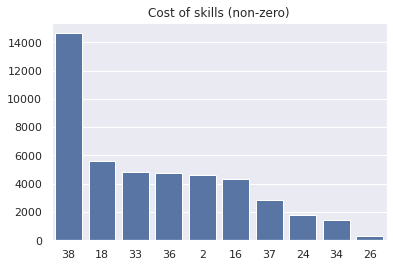

In [0]:
skill_costs = skill_delta.sum(axis=0)
skill_costs = skill_costs.sort_values(ascending=False)
data = skill_costs[skill_costs > 0]

ax = sns.barplot(data.index, data.values, order=data.index, color='b')
ax.set_title('Cost of skills (non-zero)')
plt.show()

# Q5: Annual constraint analysis
The activity at each constraint is calculated under the optimal assignment plan to check if any constraints are binding.

In [0]:
aggregates = base_solutions.groupby(['job', 'year']).sum()
aggregates[['assignment', 'time']]

assignment  time
job                      year                  
Administrative Assistant 0            2.0   5.0
                         1            2.0   5.0
                         2            1.0   5.0
Professional             0            2.0   5.0
                         1            2.0   5.0
                         2            1.0   5.0
Project Manager          0            2.0   5.0
                         1            2.0   5.0
                         2            2.0   5.0
Sales                    0            2.0   5.0
                         1            2.0   5.0
                         2            1.0   5.0
Senior Manager           0            1.0   5.0
                         1            2.0   7.0
                         2            2.0   5.0
Technician               0            2.0   5.0
                         1            2.0   5.0
                         2            1.0   5.0

From the table, we can see that only the lower bound on anual training days is binding. The upper bounds on the number of annual programs and training days are non binding as verified below.

In [0]:
prog_binding = aggregates.assignment == 5
days_binding = aggregates.time == 15
aggregates[prog_binding | days_binding]

,,program,assignment,cost,time
job,year,,,,


# Further analysis
Find optimal assignments for multiple employees with program fixed costs and program enrollment.

1. Find top k plans for each job type
2. Find near optimal mix of plans that meets enrollment constraints
3. Use near optimal solution as starting BFS in assignment to obtain optimal solution

(Todo: Think about whether dantzig-wolfe decomposition might be better)

## Step 1: K best jobs

In [0]:
# Sets
J = jobs_info.index
P = prog_info.index
S = skills_info.index
Y = np.arange(3) # The number of years

# Parameters
k = jobs_info['Salary ($)'] / 250 # annual salary / workdays per year
c = prog_info['Enrollment Cost ($)']
t = prog_info['Duration (days)']

subproblem = dict()
for j in J:
  model = pywraplp.Solver(f'{j} assignment', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
  
  # Variables
  x = defaultdict(dict)
  for p in P:
    for y in Y:
      x[p][y] = model.BoolVar(f'assign program {p} in year {y}')
  
  # Objective function
  z1 = sum(c[p]*x[p][y] for j in J for p in P for y in Y)
  z2 = sum(k[j]*t[p]*x[p][y] for j in J for p in P for y in Y)
  model.Minimize(z1 + z2)

  # Program constraints
  for p1 in P:
    for p2 in P:
      if (p2 > p1) and prog_clash.loc[p1, str(p2)] == 1:
        for y in Y:
          model.Add(x[p1][y] + x[p2][y] <= 1, f'year {y} {p1} {p2} clash')
  
  # Skill constraints
  for s in S:
    if jobs_skills.loc[j, str(s)] == 1:
      model.Add(sum(x[p][y] for p in P for y in Y if prog_skills.loc[p, str(s)]) >= 1, f'skill {s}')

  # Annual constraints
  for y in Y:
    model.Add(sum(x[p][y] for p in P) <= 5, f'year {y} max programs')
    model.Add(sum(t[p]*x[p][y] for p in P) >= 5, f'year {y} min hours')
    model.Add(sum(t[p]*x[p][y] for p in P) <= 15, f'year {y} max hours')

  subproblem[j] = (model, x, z1, z2)

In [0]:
objective_records = list()
solutions_records = list()
K = 50

for j, (model, x, z1, z2) in subproblem.items():
  print(j, end='')
  for k in range(K):
    print('.', end='')
    if model.Solve() == model.OPTIMAL:
      objective_records.append({
          'job': j,
          'plan': k,
          'real cost': z1.solution_value(),
          'opp. cost': z2.solution_value(),
          'total': model.Objective().Value(),
      })
      solutions_records.extend([{
          'job': j, 
          'plan': k,
          'program': p, 
          'year': y, 
          'assignment': x[p][y].solution_value()
      } for p in P for y in Y])

      checksum_0 = sum(x[p][y] for p in P for y in Y if int(x[p][y].solution_value())==0)      
      checksum_1 = sum(1-x[p][y] for p in P for y in Y if int(x[p][y].solution_value())==1)
      model.Add(checksum_0 + checksum_1 >= 1)
    else:
      break
  print()

base_objective = pd.DataFrame.from_records(objective_records).set_index('job')
base_solutions = pd.DataFrame.from_records(solutions_records)
base_solutions['cost'] = c[base_solutions.program].values * base_solutions.assignment
base_solutions['time'] = t[base_solutions.program].values * base_solutions.assignment

Senior Manager..................................................Project Manager..................................................Professional..................................................Sales..................................................Technician..................................................Administrative Assistant..................................................

In [0]:
for j in J:
  for k in range(K):
    # Plot assignments
    plt.figure(figsize=(5, 1))
    sns.heatmap(
        data = base_solutions[(base_solutions.job==j) & (base_solutions.plan==k)].pivot('year', 'program', 'assignment'), 
        annot = len(Y)*[P], 
        cbar=False, 
        xticklabels=False
    ).set_title(f'{j}: plan {k}')
    plt.show()

  # Print Objectives
  print(base_objective.loc[j])

In [0]:
base_objective.to_csv('top_k_objective.csv', index=False)
base_solutions.to_csv('top_k_solutions.csv', index=False)